In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
import warnings

tf.logging.set_verbosity(tf.logging.ERROR)

#### Ignore pandas warnings

In [2]:
warnings.filterwarnings('ignore')

## Get house price dataframes

In [4]:
house_data = pd.read_csv('train.csv').drop(columns=['Id', 'Alley'])
test_data = pd.read_csv('test.csv').drop(columns=['Id', 'Alley'])

In [5]:
print(house_data.shape)
print(test_data.shape)

(1460, 79)
(1459, 78)


## Explore non-numeric data

In [6]:
print('{:<20}{:^20}{:^20}'.format('COLUMNS', 'UNIQUE', 'VALUES\n'))
for col in house_data:
    if not np.issubdtype(house_data[col].dtype, np.number):
        values, unique = house_data[col].factorize()
        text = ', '.join(str(i) for i in unique)
        if len(text) > 65:
            lines = math.ceil(len(text) / 65)
            res = text[:65]
            for line in range(1, lines):
                res += '\n\t\t\t\t\t' + text[(line * 65):((line + 1) * 65)]
            text = res
        print('{:<20}{:^20}[{}]'.format(col, len(unique), text))

COLUMNS                    UNIQUE             VALUES
       
MSZoning                     5          [RL, RM, C (all), FV, RH]
Street                       2          [Pave, Grvl]
LotShape                     4          [Reg, IR1, IR2, IR3]
LandContour                  4          [Lvl, Bnk, Low, HLS]
Utilities                    2          [AllPub, NoSeWa]
LotConfig                    5          [Inside, FR2, Corner, CulDSac, FR3]
LandSlope                    3          [Gtl, Mod, Sev]
Neighborhood                 25         [CollgCr, Veenker, Crawfor, NoRidge, Mitchel, Somerst, NWAmes, Old
					Town, BrkSide, Sawyer, NridgHt, NAmes, SawyerW, IDOTRR, MeadowV, 
					Edwards, Timber, Gilbert, StoneBr, ClearCr, NPkVill, Blmngtn, BrD
					ale, SWISU, Blueste]
Condition1                   9          [Norm, Feedr, PosN, Artery, RRAe, RRNn, RRAn, PosA, RRNe]
Condition2                   8          [Norm, Artery, RRNn, Feedr, PosN, PosA, RRAn, RRAe]
BldgType                     5          [1Fa

## Plot histogram for the sale prices

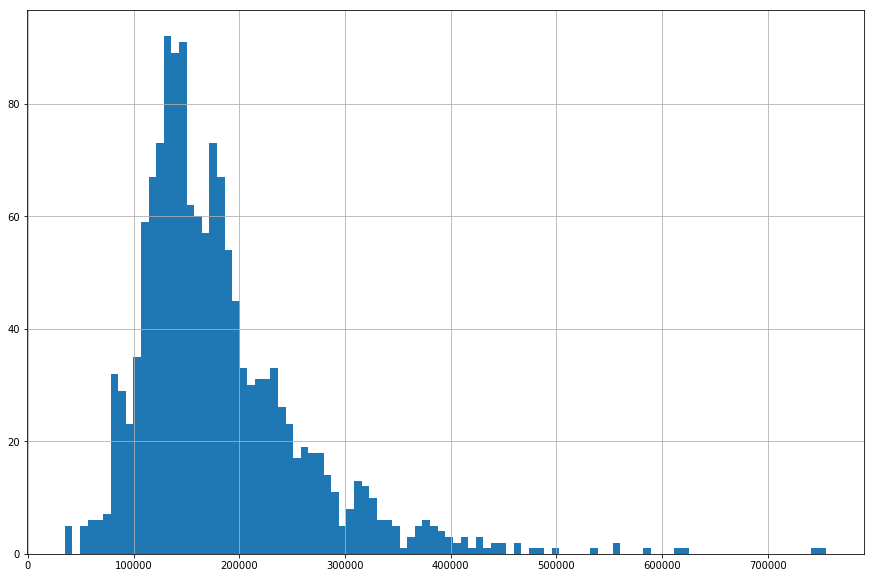

In [7]:
plt.figure(figsize=(15,10))
house_data['SalePrice'].hist(bins=100)

## Explore data related to garage

### Get list of garage columns

In [13]:
garage_lst = []
for col in house_data:
    if col.find('Garage') != -1:
        garage_lst.append(col)
garage_df = house_data[garage_lst]
garage_df['SalePrice'] = house_data['SalePrice']

In [14]:
test_garage_lst = []
for col in test_data:
    if col.find('Garage') != -1:
        test_garage_lst.append(col)
test_garage_df = test_data[test_garage_lst]

### Replace missing years by 1899. Year classes will be corrected later

In [15]:
bins_year = pd.qcut(garage_df['GarageYrBlt'].fillna(1899), q=5, labels=[1,2,3,4,5])
bins_area = pd.qcut(garage_df['GarageArea'], q=5, labels=[1,2,3,4,5])
garage_df['GarageYrBlt'] = pd.to_numeric(bins_year)
garage_df['GarageArea'] = pd.to_numeric(bins_area)

test_bins_year = pd.qcut(test_garage_df['GarageYrBlt'].fillna(1899), q=5, labels=[1,2,3,4,5])
test_bins_area = pd.qcut(test_garage_df['GarageArea'], q=5, labels=[1,2,3,4,5])
test_garage_df['GarageYrBlt'] = pd.to_numeric(test_bins_year)
test_garage_df['GarageArea'] = pd.to_numeric(test_bins_area)

### Build scatter plots for garage area and year

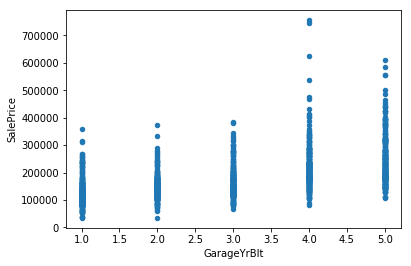

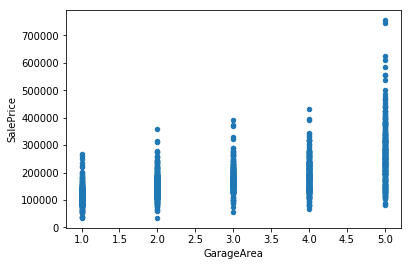

In [17]:
garage_df.plot.scatter(x='GarageYrBlt', y='SalePrice')
garage_df.plot.scatter(x='GarageArea', y='SalePrice')

## Fill missing numeric data

In [19]:
# fill missing numeric values by zeros, since nan in this case means zero cars and zero area

test_garage_df[['GarageCars', 'GarageArea']] = test_garage_df[['GarageCars', 'GarageArea']].fillna(0)

garage_df.fillna('NA', inplace=True)
test_garage_df.fillna('NA', inplace=True)

## Convert non-numeric classes to price-weighted classes

### Garage

#### Get mapping dictionary

In [31]:
mapping_dict = {}

for col in garage_lst:
    
    uniq_dict = defaultdict(list)
    
    # create dictionary {class: list of prices}
    for i in range(len(garage_df)):
        uniq_dict[garage_df[col][i]].append(house_data['SalePrice'][i])
    
    # find mean price value for each class in dictionary
    for item in uniq_dict:
        uniq_dict[item] = sum(uniq_dict[item]) / len(uniq_dict[item])
    
    # convert dictionary to list of tuples [(class, mean_price), ...]
    dlst = uniq_dict.items()
    lst = [*dlst]
    
    # sort list of tuples by mean_price
    lst.sort(key=lambda x: x[1])
    
    # convert classes to float coefficients using (mean_price_for_class / max_mean_value)
    classes, mean_prices = zip(*lst)
    max_mean_price = max(mean_prices)
    numeric_class_list = []
    for i in range(len(classes)):
        numeric_class_list.append(round(mean_prices[i] / max_mean_price, 2))
    
    #create mapping class: numeric_class
    mapping = dict(zip(list(classes), numeric_class_list))
    
    # append {feature:mapping} to mapping_list
    mapping_dict.update({col:mapping})

In [32]:
# check mapping

for _dict, val in mapping_dict.items():
    text = str(val)
    if len(text) > 95:
        lines = math.ceil(len(text) / 95)
        res = text[:95]
        for line in range(1, lines):
            res += '\n\t\t' + text[(line * 95):((line + 1) * 95)]
        text = res
    print('{:<15}{}'.format(_dict, text))

GarageType     {'NA': 0.41, 'CarPort': 0.43, 'Detchd': 0.53, '2Types': 0.59, 'Basment': 0.63, 'Attchd': 0.8, '
		BuiltIn': 1.0}
GarageYrBlt    {1: 0.53, 2: 0.6, 3: 0.67, 4: 0.89, 5: 1.0}
GarageFinish   {'NA': 0.43, 'Unf': 0.59, 'RFn': 0.84, 'Fin': 1.0}
GarageCars     {0: 0.33, 1: 0.41, 2: 0.59, 4: 0.62, 3: 1.0}
GarageArea     {1: 0.45, 2: 0.57, 3: 0.67, 4: 0.71, 5: 1.0}
GarageQual     {'Po': 0.42, 'NA': 0.43, 'Fa': 0.51, 'TA': 0.78, 'Gd': 0.9, 'Ex': 1.0}
GarageCond     {'NA': 0.55, 'Po': 0.58, 'Fa': 0.61, 'Ex': 0.66, 'Gd': 0.96, 'TA': 1.0}


#### Using mapping, replace classes in each column with corresponding numeric class

In [33]:
for col in mapping_dict:
    
    mapping = mapping_dict[col]
    
    garage_df[col].replace(to_replace=mapping, inplace=True)
    test_garage_df[col].replace(to_replace=mapping, inplace=True)

#### Build scatter plots

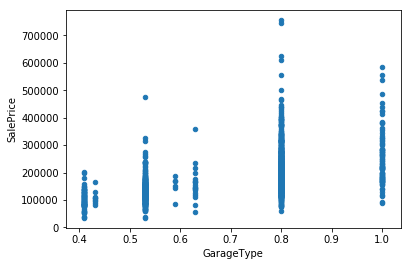

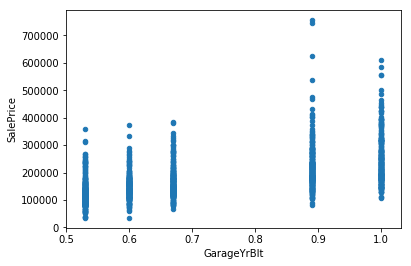

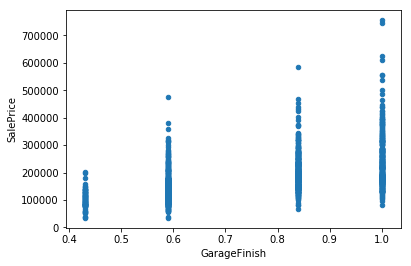

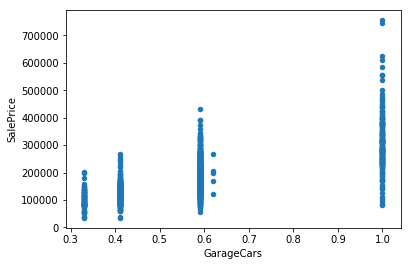

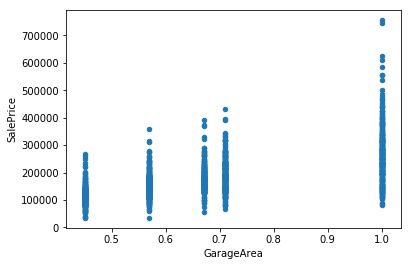

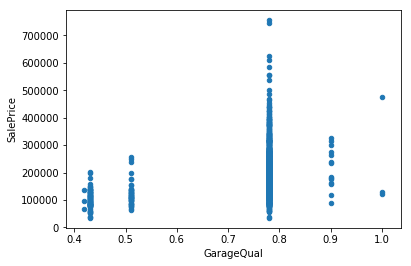

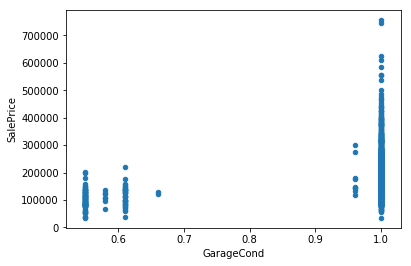

In [37]:
for col in garage_df:
    if col == 'SalePrice':
        continue
    garage_df.plot.scatter(x=col, y='SalePrice')
    plt.show()

#### Append new garage feature columns to main dataframe 

In [38]:
house_data[garage_lst] = garage_df[garage_lst]
test_data[test_garage_lst] = test_garage_df[test_garage_lst]

### Basement

In [40]:
base_lst = ['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual']
base_df = house_data[base_lst]
test_base_df = test_data[base_lst]

In [41]:
base_df.fillna('NA', inplace=True)
test_base_df.fillna('NA', inplace=True)

#### Get mapping

In [42]:
mapping_dict = {}

for col in base_lst:
    
    uniq_dict = defaultdict(list)
    
    # create dictionary {class: list of prices}
    for i in range(len(base_df)):
        uniq_dict[base_df[col][i]].append(house_data['SalePrice'][i])
    
    # find mean price value for each class in dictionary
    for item in uniq_dict:
        uniq_dict[item] = sum(uniq_dict[item]) / len(uniq_dict[item])
    
    # convert dictionary to list of tuples [(class, mean_price), ...]
    dlst = uniq_dict.items()
    lst = [*dlst]
    
    # sort list of tuples by mean_price
    lst.sort(key=lambda x: x[1])
    
    # convert classes to float coefficients using (mean_price_for_class / max_mean_value)
    classes, mean_prices = zip(*lst)
    max_mean_price = max(mean_prices)
    numeric_class_list = []
    for i in range(len(classes)):
        numeric_class_list.append(round(mean_prices[i] / max_mean_price, 2))
    
    #create mapping class: numeric_class
    mapping = dict(zip(list(classes), numeric_class_list))
    
    # append {feature:mapping} to mapping_list
    mapping_dict.update({col:mapping})

In [43]:
# check mapping

for _dict, val in mapping_dict.items():
    text = str(val)
    if len(text) > 95:
        lines = math.ceil(len(text) / 95)
        res = text[:95]
        for line in range(1, lines):
            res += '\n\t\t' + text[(line * 95):((line + 1) * 95)]
        text = res
    print('{:<15}{}'.format(_dict, text))

BsmtCond       {'Po': 0.3, 'NA': 0.49, 'Fa': 0.57, 'TA': 0.86, 'Gd': 1.0}
BsmtExposure   {'NA': 0.42, 'No': 0.64, 'Mn': 0.75, 'Av': 0.8, 'Gd': 1.0}
BsmtFinType1   {'NA': 0.45, 'Rec': 0.62, 'BLQ': 0.64, 'LwQ': 0.65, 'ALQ': 0.69, 'Unf': 0.72, 'GLQ': 1.0}
BsmtFinType2   {'NA': 0.53, 'BLQ': 0.72, 'LwQ': 0.78, 'Rec': 0.79, 'GLQ': 0.86, 'Unf': 0.88, 'ALQ': 1.0}
BsmtQual       {'NA': 0.32, 'Fa': 0.35, 'TA': 0.43, 'Gd': 0.62, 'Ex': 1.0}


#### Using mapping, replace classes in each column with corresponding numeric class

In [44]:
for col in mapping_dict:
    
    mapping = mapping_dict[col]
    
    base_df[col].replace(to_replace=mapping, inplace=True)
    test_base_df[col].replace(to_replace=mapping, inplace=True)

#### Build scatter plots

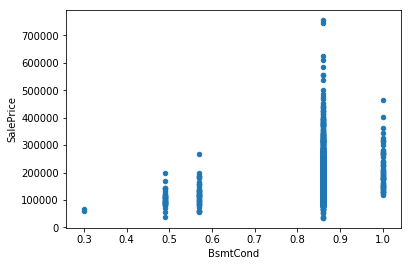

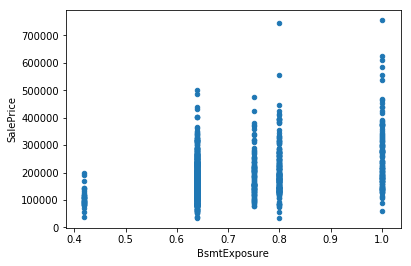

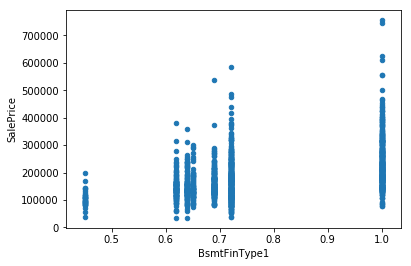

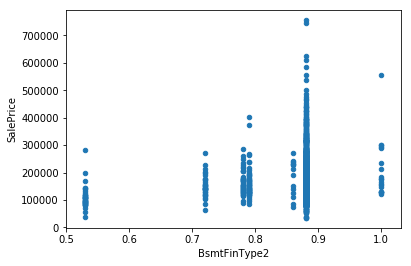

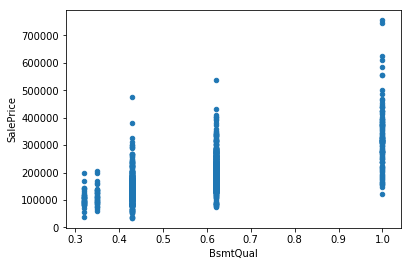

In [47]:
base_df['SalePrice'] = house_data['SalePrice']

for col in base_df:
    if col == 'SalePrice':
        continue
    base_df.plot.scatter(x=col, y='SalePrice')
    plt.show()

#### Append new basement feature columns to main dataframe 

In [48]:
house_data[base_lst] = base_df[base_lst]
test_data[base_lst] = test_base_df[base_lst]

## Get difference between unique values in train and test dataframe columns

### Get list of unwanted columns

In [51]:
uniq_lst = []
test_uniq_lst = []

lst = []

for col in list(house_data.drop(columns='SalePrice')):
    if not np.issubdtype(house_data[col].dtype, np.number):
        lst.append(col)

for col in lst:
    uniq_lst.append(house_data[col].unique())
    test_uniq_lst.append(test_data[col].unique())

del_lst = []

print('{:<16}{:^5}'.format('COL', 'DIFF_COUNT\n'))

for i in range(len(uniq_lst)):
    
    a = uniq_lst[i]
    b = test_uniq_lst[i]
    
    print('{:<16}{}'.format(lst[i], len(set(a) ^ set(b))))
    
    if len(set(a) ^ set(b)) > 0:
        del_lst.append(lst[i])

print('\nColumns: ', del_lst)

COL             DIFF_COUNT

MSZoning        1
Street          0
LotShape        0
LandContour     0
Utilities       2
LotConfig       0
LandSlope       0
Neighborhood    0
Condition1      0
Condition2      3
BldgType        0
HouseStyle      1
RoofStyle       0
RoofMatl        4
Exterior1st     3
Exterior2nd     2
MasVnrType      0
ExterQual       0
ExterCond       0
Foundation      0
Heating         2
HeatingQC       0
CentralAir      0
Electrical      2
KitchenQual     1
Functional      1
FireplaceQu     0
PavedDrive      0
PoolQC          1
Fence           0
MiscFeature     1
SaleType        1
SaleCondition   0

Columns:  ['MSZoning', 'Utilities', 'Condition2', 'HouseStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'Heating', 'Electrical', 'KitchenQual', 'Functional', 'PoolQC', 'MiscFeature', 'SaleType']


### Drop that columns

In [52]:
house_data.drop(columns=del_lst, inplace=True)
test_data.drop(columns=del_lst, inplace=True)

## Get columns in test dataframe that don't exist in train dataframe

In [53]:
col_lst = []
test_col_lst = []

for col in house_data:
    col_lst.append(col)

for col in test_data:
    test_col_lst.append(col)

del_lst = []

print('{:<12}{}'.format('Columns:', set(col_lst) ^ set(test_col_lst)))

del_lst.append(set(col_lst) ^ set(test_col_lst))

Columns:    {'SalePrice'}


In [54]:
# check shapes

print(house_data.shape)
print(test_data.shape)

(1460, 65)
(1459, 64)


## Other classes

#### Get columns with non-numeric data

In [56]:
other_lst = []
for col in house_data:
    if not np.issubdtype(house_data[col].dtype, np.number):
        other_lst.append(col)
other_lst.sort()
print(*other_lst, sep='\n')

BldgType
CentralAir
Condition1
ExterCond
ExterQual
Fence
FireplaceQu
Foundation
HeatingQC
LandContour
LandSlope
LotConfig
LotShape
MasVnrType
Neighborhood
PavedDrive
RoofStyle
SaleCondition
Street


In [57]:
# create 'other' dataframe

other_df = house_data[other_lst]
test_other_df = test_data[other_lst]

In [58]:
other_df.fillna('NA', inplace=True)
test_other_df.fillna('NA', inplace=True)

#### Get mapping dictionary

In [59]:
mapping_dict = {}

for col in other_lst:
    
    uniq_dict = defaultdict(list)
    
    # create dictionary {class: list of prices}
    for i in range(len(other_df)):
        uniq_dict[other_df[col][i]].append(house_data['SalePrice'][i])
    
    # find mean price value for each class in dictionary
    for item in uniq_dict:
        uniq_dict[item] = sum(uniq_dict[item]) / len(uniq_dict[item])
    
    # convert dictionary to list of tuples [(class, mean_price), ...]
    dlst = uniq_dict.items()
    lst = [*dlst]
    
    # sort list of tuples by mean_price
    lst.sort(key=lambda x: x[1])
    
    # convert classes to float coefficients using (mean_price_for_class / max_mean_value)
    classes, mean_prices = zip(*lst)
    max_mean_price = max(mean_prices)
    numeric_class_list = []
    for i in range(len(classes)):
        numeric_class_list.append(round(mean_prices[i] / max_mean_price, 2))
    
    # create mapping {class: numeric_class}
    mapping = dict(zip(list(classes), numeric_class_list))
    
    # append {feature:mapping} to mapping_list
    mapping_dict.update({col:mapping})

In [60]:
# check mapping

for _dict, val in mapping_dict.items():
    text = str(val)
    if len(text) > 95:
        lines = math.ceil(len(text) / 95)
        res = text[:95]
        for line in range(1, lines):
            res += '\n\t\t' + text[(line * 95):((line + 1) * 95)]
        text = res
    print('{:<15}{}'.format(_dict, text))

BldgType       {'2fmCon': 0.69, 'Duplex': 0.72, 'Twnhs': 0.73, 'TwnhsE': 0.98, '1Fam': 1.0}
CentralAir     {'N': 0.57, 'Y': 1.0}
Condition1     {'Artery': 0.6, 'RRAe': 0.61, 'Feedr': 0.63, 'RRAn': 0.82, 'Norm': 0.82, 'RRNe': 0.84, 'RRNn': 
		0.94, 'PosN': 0.95, 'PosA': 1.0}
ExterCond      {'Po': 0.38, 'Fa': 0.51, 'Gd': 0.84, 'TA': 0.91, 'Ex': 1.0}
ExterQual      {'Fa': 0.24, 'TA': 0.39, 'Gd': 0.63, 'Ex': 1.0}
Fence          {'MnWw': 0.72, 'GdWo': 0.75, 'MnPrv': 0.79, 'GdPrv': 0.95, 'NA': 1.0}
FireplaceQu    {'Po': 0.38, 'NA': 0.42, 'Fa': 0.5, 'TA': 0.61, 'Gd': 0.67, 'Ex': 1.0}
Foundation     {'Slab': 0.48, 'BrkTil': 0.59, 'CBlock': 0.67, 'Stone': 0.74, 'Wood': 0.82, 'PConc': 1.0}
HeatingQC      {'Po': 0.4, 'Fa': 0.58, 'TA': 0.66, 'Gd': 0.73, 'Ex': 1.0}
LandContour    {'Bnk': 0.62, 'Lvl': 0.78, 'Low': 0.88, 'HLS': 1.0}
LandSlope      {'Gtl': 0.88, 'Mod': 0.96, 'Sev': 1.0}
LotConfig      {'Inside': 0.79, 'FR2': 0.79, 'Corner': 0.81, 'FR3': 0.93, 'CulDSac': 1.0}
LotShape       {'Reg': 0.6

#### Using mapping, replace classes in each column with corresponding numeric class

In [61]:
for col in mapping_dict:
    
    mapping = mapping_dict[col]
    
    other_df[col].replace(to_replace=mapping, inplace=True)
    test_other_df[col].replace(to_replace=mapping, inplace=True)

#### Build scatter plots

In [64]:
other_df['SalePrice'] = house_data['SalePrice']

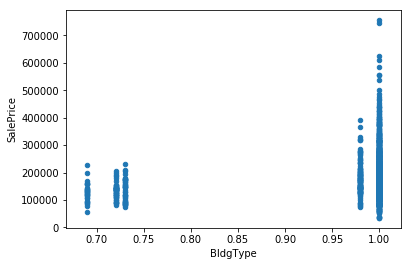

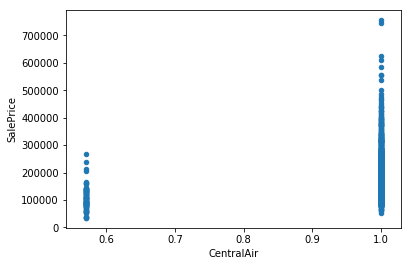

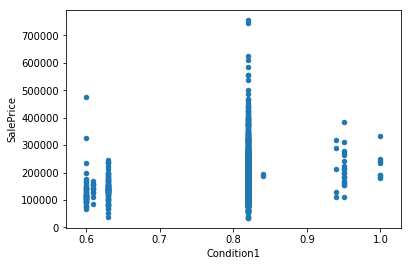

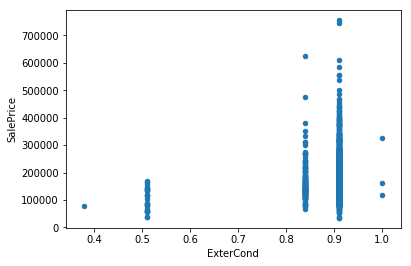

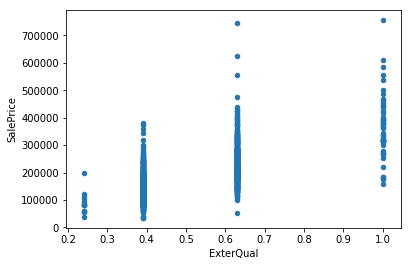

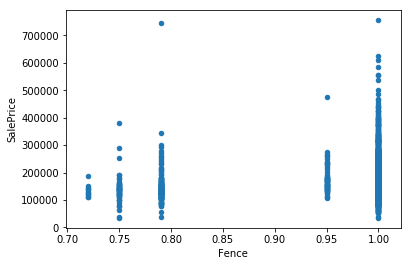

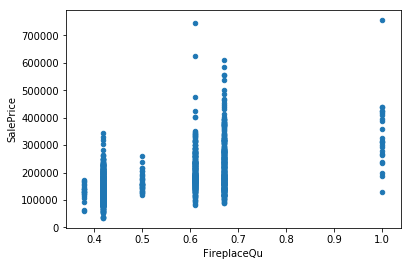

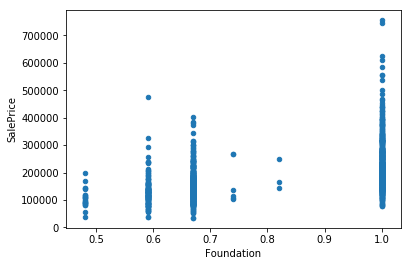

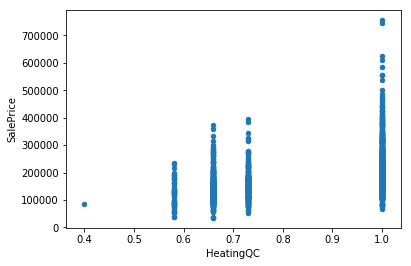

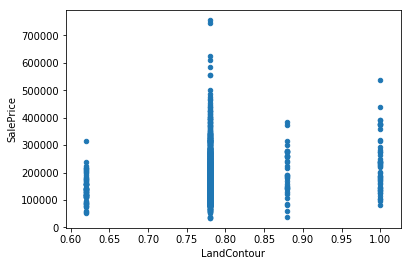

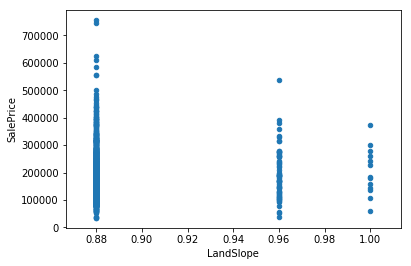

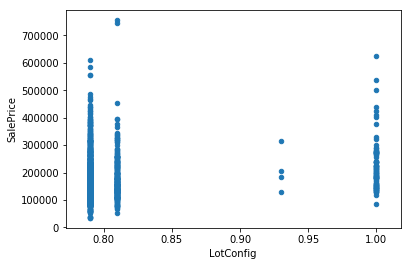

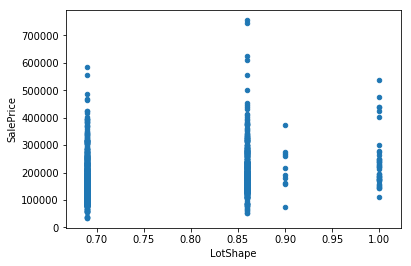

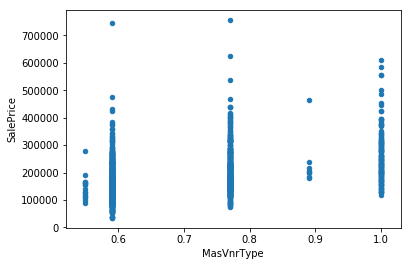

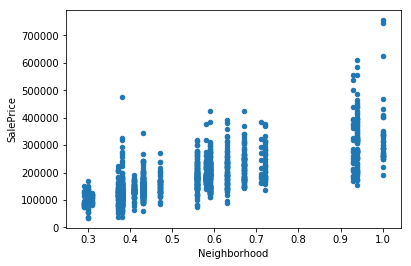

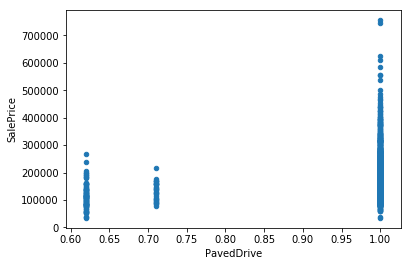

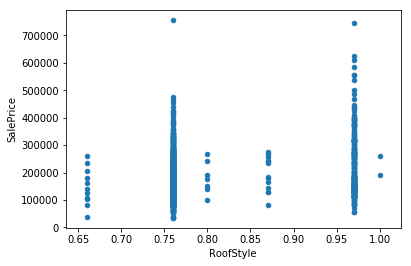

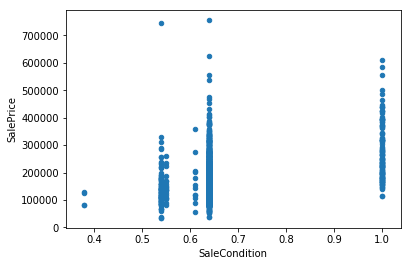

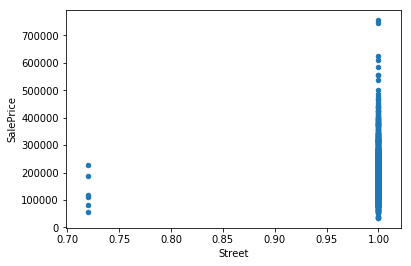

In [65]:
for col in other_df:
    if col == 'SalePrice':
        continue
    other_df.plot.scatter(x=col, y='SalePrice')
    plt.show()

#### Append new features columns to main dataframe

In [66]:
house_data[other_lst] = other_df[other_lst]
test_data[other_lst] = test_other_df[other_lst]

In [68]:
# check shapes

print(house_data.shape)
print(test_data.shape)

(1460, 65)
(1459, 64)


## Check numeric data for NaN values

### Get list of columns with missing data

In [70]:
lst = []
for col in house_data:
    if house_data[col].isna().any():
        lst.append(col)
lst.sort()
print(*lst, sep='\n')

LotFrontage
MasVnrArea


In [71]:
lst = []
for col in test_data:
    if test_data[col].isna().any():
        lst.append(col)
lst.sort()
print(*lst, sep='\n')

BsmtFinSF1
BsmtFinSF2
BsmtFullBath
BsmtHalfBath
BsmtUnfSF
LotFrontage
MasVnrArea
TotalBsmtSF


### Fill missing values by zeros

In [72]:
house_data.fillna(0, inplace=True)
test_data.fillna(0, inplace=True)

## Normalize dataframe columns

In [73]:
for col in house_data:
    if col == 'SalePrice':
        continue
    house_data[col] = (house_data[col] - min(house_data[col])) / (max(house_data[col]) - min(house_data[col]))
    test_data[col] = (test_data[col] - min(test_data[col])) / (max(test_data[col]) - min(test_data[col]))

## Get feature sequences with high correlations to the sale price

### Check all sequences

In [122]:
THRESHOLD_FOR_PRICE = 0.8

permuts = []

# huge - sequence dataframe
huge = pd.DataFrame()

# dummy - house_data copy
dummy = house_data

for x in range(1, 10, 1):

    THRESHOLD = x / 10
    
    # for each column in dummy...
    for col in list(dummy.drop(columns='SalePrice')):
        
        # ...copy that column to huge...
        huge[col] = dummy[col]
        
        # ...track that column as previous...
        prev = col
    
        # ...check what is the correlation between that column and rest of the columns (sub_columns)
        for sub_column in dummy.drop(columns=[col,'SalePrice']):
        
            # copy sub_column to huge...
            huge[sub_column] = dummy[sub_column]
        
            # ...calculate correlation between column and sub_column
            corr = huge[[prev, sub_column]].corr().iloc[0,1]
        
            # if correlation is higher than selected threshold...
            if corr >= THRESHOLD:

                # ...create new column with explanatory name and assign values = mean(column.values and sub_column.values)...
                huge[prev + '___' + sub_column] = huge[[prev, sub_column]].mean(axis=1)
            
                # ...get correlation of newly created feature with the price (which is temporarily added)
                huge['SalePrice'] = dummy['SalePrice']
                corr = huge[[prev + '___' + sub_column, 'SalePrice']].corr().iloc[0,1]
                huge.drop(columns=['SalePrice'], inplace=True)
            
                # drop new column if correlation is not high enough, else - keep it
                if corr < THRESHOLD_FOR_PRICE:
                    huge.drop(columns=[prev + '___' + sub_column], inplace=True)
                else:
                    # ...drop previous column, cause we gonna replace it with new one (with longer sequence)...
                    huge.drop(columns=prev, inplace=True)
                
                    # ...update previous column name with the name of newly added column
                    prev = prev + '___' + sub_column
                    
                    # ...track column sequences in a list
                    permuts.append(list(prev.split('___')))
            
            # drop sub_column column, we don't want it in resulting dataframe...
            huge.drop(columns=sub_column, inplace=True)
        
        # ...same for initial column, drop it
        huge.drop(columns=col, inplace=True, errors='ignore')

# ...get rid of duplicate sequences in permuts
permuts.sort()
combs = list(permuts for permuts,_ in itertools.groupby(permuts))

# PRINT RESULTS
print(*combs, sep='\n')

['GrLivArea', 'OverallQual']
['GrLivArea', 'OverallQual', 'TotalBsmtSF']
['OverallQual', 'GrLivArea']


### Get sequences longer than specified threshold

In [66]:
SEQ_LEN = 6

final_combs = [item for item in combs if len(item) >= SEQ_LEN]
print(*final_combs, sep='\n')

['1stFlrSF', 'Neighborhood', 'OverallQual', 'MasVnrArea', 'TotalBsmtSF', 'GrLivArea']
['GarageCars', 'Neighborhood', 'OverallQual', 'ExterQual', 'TotalBsmtSF', '1stFlrSF']
['GarageCars', 'Neighborhood', 'OverallQual', 'ExterQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea']
['GarageCars', 'Neighborhood', 'OverallQual', 'MasVnrArea', 'ExterQual', 'BsmtFinSF1']
['GarageCars', 'Neighborhood', 'OverallQual', 'MasVnrArea', 'ExterQual', 'BsmtFinSF1', 'GrLivArea']
['GarageCars', 'Neighborhood', 'OverallQual', 'MasVnrArea', 'ExterQual', 'TotalBsmtSF']
['GarageCars', 'Neighborhood', 'OverallQual', 'MasVnrArea', 'ExterQual', 'TotalBsmtSF', 'GrLivArea']
['Neighborhood', 'OverallQual', 'ExterQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea']
['OverallQual', 'LotArea', 'Neighborhood', 'ExterQual', 'BsmtFinSF1', '1stFlrSF']
['OverallQual', 'LotArea', 'Neighborhood', 'ExterQual', 'BsmtFinSF1', '1stFlrSF', 'GrLivArea']
['OverallQual', 'Neighborhood', 'ExterQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea']
['TotR

### Select one sequence and create new combined feature column

In [76]:
final_combs = [['GrLivArea', 'OverallQual', 'TotalBsmtSF']]

### Build scatter plot

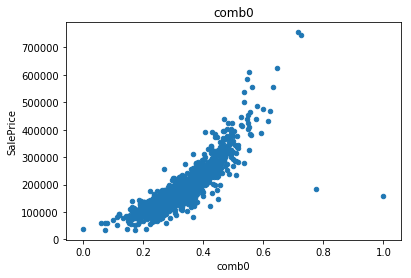

In [81]:
# train data
new_features = pd.DataFrame()
new_features['SalePrice'] = house_data['SalePrice']

for i in range(len(final_combs)):
    new_features['comb' + str(i)] = house_data[final_combs[i]].mean(axis=1)
    new_features.plot.scatter(x='comb' + str(i), y='SalePrice', title='comb' + str(i))

# test data    
new_test_features = pd.DataFrame()

for i in range(len(final_combs)):
    new_test_features['comb' + str(i)] = test_data[final_combs[i]].mean(axis=1)

### Remove outliers

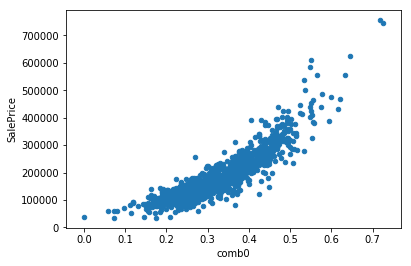

In [82]:
for row in new_features.index:
    if new_features.iloc[row,1] > 0.75 and new_features.iloc[row,0] < 250000:
        new_features.iloc[row,1] = 0.35

new_features.plot.scatter(x='comb0', y='SalePrice')

### Divide price values by 1000

In [94]:
new_features['SalePrice'] = new_features['SalePrice'] / 1000

### Plot histograms

#### Train data

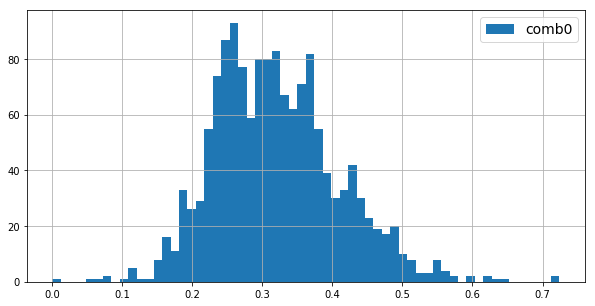

In [83]:
for col in new_features:
    if col == 'SalePrice':
        continue
    plt.figure(figsize=(10,5))
    new_features[col].hist(bins=60)
    plt.legend([col], fontsize=14, loc='upper right')
    plt.show()

#### Test data

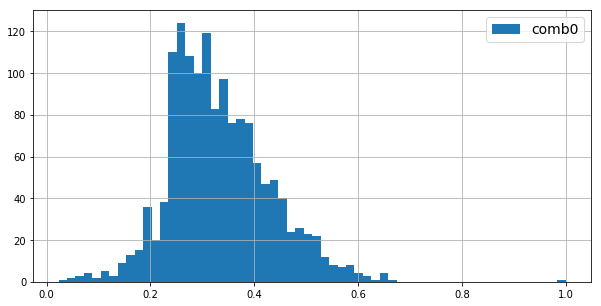

In [84]:
for col in new_test_features:
    plt.figure(figsize=(10,5))
    new_test_features[col].hist(bins=60)
    plt.legend([col], fontsize=14, loc='upper right')
    plt.show()

## Use created feature to train model

In [96]:
house_data_final = new_features
test_data_final = new_test_features

## Split data

In [97]:
train_examples = np.asarray(house_data_final.iloc[:1000,:].drop(columns=['SalePrice']), dtype=np.float32)
valid_examples = np.asarray(house_data_final.iloc[1000:,:].drop(columns=['SalePrice']), dtype=np.float32)

train_targets = np.asarray(house_data_final['SalePrice'][:1000], dtype=np.int32)
valid_targets = np.asarray(house_data_final['SalePrice'][1000:], dtype=np.int32)

test_examples = np.asarray(test_data_final, dtype=np.float32)

In [98]:
print(train_examples.shape, type(train_examples))
print(valid_examples.shape, type(valid_examples))

print(train_targets.shape, type(train_targets))
print(valid_targets.shape, type(valid_targets))

print(test_examples.shape, type(test_examples))

(1000, 1) <class 'numpy.ndarray'>
(460, 1) <class 'numpy.ndarray'>
(1000,) <class 'numpy.ndarray'>
(460,) <class 'numpy.ndarray'>
(1459, 1) <class 'numpy.ndarray'>


## Numpy input functions

In [99]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x':train_examples},
    y=train_targets,
    batch_size=5,
    num_epochs=1,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x':train_examples},
    y=train_targets,
    num_epochs=1,
    shuffle=False)

validate_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x':valid_examples},
    y=valid_targets,
    num_epochs=1,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x':test_examples},
    num_epochs=1,
    shuffle=False)

## NN regressor

In [100]:
def dnn_model_fn(features, labels, mode):
    
    reshape_layer_1 = tf.reshape(features['x'], [-1, train_examples.shape[1]])
    
    dense_layer_1 = tf.layers.dense(
        inputs=reshape_layer_1,
        units=100)
    
    dropout_layer_1 = tf.layers.dropout(
        inputs=dense_layer_1,
        rate=0.5,
        training=(mode == tf.estimator.ModeKeys.TRAIN))
    
    dense_layer_2 = tf.layers.dense(
        inputs=dropout_layer_1,
        units=100)
    
    final_layer = tf.contrib.layers.fully_connected(
        inputs=dense_layer_2,
        num_outputs=1)
    
    final_layer = tf.reduce_mean(
        input_tensor=final_layer,
        axis=1)
    
    predictions = {'price': final_layer}
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    loss = tf.sqrt(tf.losses.mean_squared_error(
        labels=labels,
        predictions=final_layer))
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        train_optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_optimizer)
    
    # mode = EVAL
    
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss)

## Configure estimator

In [101]:
OUTDIR = './dnn_house_data'

dnn_regressor = tf.estimator.Estimator(model_fn=dnn_model_fn, model_dir=OUTDIR)

file_writer = tf.summary.FileWriter(OUTDIR)

## Train function

In [102]:
def train_and_evaluate(estimator, epochs=20):

    all_train_log = []
    all_validate_log = []
    
    for epoch in range(epochs):
            
        estimator.train(input_fn=train_input_fn)
        
        train_log = estimator.evaluate(input_fn=eval_input_fn)
        print('STEP: {} of {}'.format(epoch + 1, epochs))
        print('TRAIN: loss={:.8f}'.format(train_log['loss']))
        
        validate_log = estimator.evaluate(input_fn=validate_input_fn)
        print('VALID: loss={:.8f}'.format(validate_log['loss']))
        
        all_train_log.append(train_log)
        all_validate_log.append(validate_log)
            
    return all_train_log, all_validate_log

## Train

In [103]:
# TRAIN MODEL
train_log, validate_log = train_and_evaluate(dnn_regressor, epochs=20)

STEP: 1 of 20
TRAIN: loss=64.37813568
VALID: loss=61.06738663
STEP: 2 of 20
TRAIN: loss=62.87788391
VALID: loss=59.22922897
STEP: 3 of 20
TRAIN: loss=58.72103500
VALID: loss=56.42530060
STEP: 4 of 20
TRAIN: loss=55.50809479
VALID: loss=52.59648132
STEP: 5 of 20
TRAIN: loss=51.60803223
VALID: loss=49.17093658
STEP: 6 of 20
TRAIN: loss=48.27939606
VALID: loss=45.79057693
STEP: 7 of 20
TRAIN: loss=44.89313507
VALID: loss=42.65151978
STEP: 8 of 20
TRAIN: loss=40.71319580
VALID: loss=39.55509949
STEP: 9 of 20
TRAIN: loss=38.79957199
VALID: loss=37.70079422
STEP: 10 of 20
TRAIN: loss=39.91384888
VALID: loss=38.68136978
STEP: 11 of 20
TRAIN: loss=36.93012238
VALID: loss=36.71717834
STEP: 12 of 20
TRAIN: loss=37.79188538
VALID: loss=37.09586716
STEP: 13 of 20
TRAIN: loss=36.58771515
VALID: loss=36.31498337
STEP: 14 of 20
TRAIN: loss=37.95460892
VALID: loss=37.32923889
STEP: 15 of 20
TRAIN: loss=36.74839783
VALID: loss=36.43787003
STEP: 16 of 20
TRAIN: loss=37.07262421
VALID: loss=36.70405960
S

## Plot loss

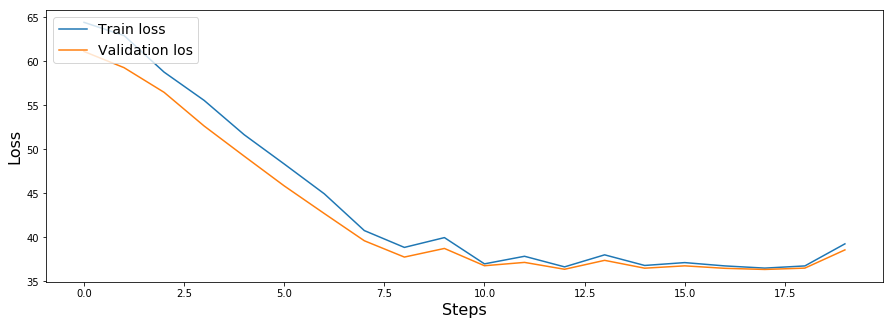

In [105]:
train_loss = [i['loss'] for i in train_log]
valid_loss = [i['loss'] for i in validate_log]

plt.figure(figsize=(15, 5))
plt.plot(train_loss)
plt.plot(valid_loss)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Steps', fontsize=16)
plt.legend(['Train loss', 'Validation los'], fontsize=14, loc='upper left')
plt.show()

## Predict and create submission file

In [106]:
# get house ids from teest dataframe
ids = pd.read_csv('test.csv')['Id']

In [107]:
# create kaggle submission file
# in predict mode model returns generator
predict_generator = dnn_regressor.predict(input_fn=predict_input_fn)

# create list of dict [{class:class, probability:probability}, ... ]
predict_dictlist = [next(predict_generator) for i in range(len(test_examples))]

prices = [predict_dictlist[item]['price'] for item in range(len(predict_dictlist))]

def create_submission_df(price_predictions, file_name):
    submission_df = pd.DataFrame()
    submission_df['Id'] = ids
    submission_df['SalePrice'] = price_predictions
    submission_df['SalePrice'] = submission_df['SalePrice'] * 1000
    submission_df.to_csv(file_name, index=False)
    print('Saved predictions to', file_name)

create_submission_df(prices, 'submission.csv')

Saved predictions to submission.csv
